In [1]:
#!pip install pyro-ppl==1.5.2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
import seaborn as sns
import torch

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

In /Users/kuba/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/kuba/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/kuba/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/kuba/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/kuba/anaconda3/lib/python3.7/site-packages/matplotlib/

In [2]:
df = pd.read_csv("Data/cces_all_clean.csv")
states = pd.read_excel("Data/states.xlsx")
df.head()
states = states.rename(columns={'republican support percentage':"rep_sup"})
states.tail()

,states,rep_sup,region
45,VT,0.30,northeast
46,WA,0.36,west
47,WI,0.47,midwest
48,WV,0.68,southeast
49,WY,0.67,west


In [3]:
categories = ["state", "eth", "male", "age", "educ"]
for category in categories:
    df[category+"_cat"] = df[category].astype('category').cat.codes
states["region"] = states["region"].astype('category').cat.codes

In [4]:
states

,states,rep_sup,region
0,AK,0.51,4
1,AL,0.62,2
2,AR,0.60,2
3,AZ,0.48,3
4,CA,0.31,4
5,CO,0.43,4
6,CT,0.40,1
7,DE,0.41,2
8,FL,0.49,2
9,GA,0.50,2


In [6]:
states_x = states.iloc[:,1:].values
states_x = torch.tensor(states_x).float()
#states

In [8]:
mat = df.iloc[:,6:].values
X = mat
X = torch.tensor(X).float()
y = df.iloc[:,0].values
y = torch.tensor(y).float()
print(X.shape)
print(states_x.shape)
print(y)

torch.Size([59810, 5])
torch.Size([50, 2])
tensor([1., 1., 1.,  ..., 0., 0., 0.])


In [104]:
from torch import sigmoid
def model(X, states_x, obs=None):
    
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5.))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros(7), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros(5), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros(4), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros(6), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4)), sigmas[5]))
    
    ####################
    #alpha_state = pyro.sample("alpha_state", dist.Normal(torch.zeros(50), sigmas[6]))
    ####################
    
    beta_male = pyro.sample("beta_male", dist.Normal(0.,5.))
    with pyro.plate("data", size=len(X), subsample_size=1000) as ind:
        state = X[ind,0].tolist()
        eth = X[ind,1].tolist()
        male = X[ind,2].tolist()
        male_t = X[ind,2]
        age = X[ind,3].tolist()
        educ = X[ind,4].tolist()
        y = pyro.sample("y",dist.Bernoulli(sigmoid(gammas[5] + gammas[6]* states_x[:,0][state] + gammas[states_x[:,1][state].tolist()]+ alpha_educ[educ] + alpha_eth[eth] + alpha_age[age] + alpha_male_eth[male, eth] + alpha_educ_age[educ,age] + alpha_educ_eth[educ, eth] + beta_male*male_t)), obs= obs[ind])
    return y

In [105]:

# Define guide function
guide = AutoDiagonalNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 12000

# Setup the optimizer
adam_params = {"lr": 0.01}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=3)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X,states_x,y)
    if step % 500 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 204202.5
[500] ELBO: 40124.4
[1000] ELBO: 40028.8
[1500] ELBO: 39714.6
[2000] ELBO: 39535.3
[2500] ELBO: 39798.7
[3000] ELBO: 40221.2
[3500] ELBO: 40100.8
[4000] ELBO: 39759.3
[4500] ELBO: 39869.0
[5000] ELBO: 39582.7
[5500] ELBO: 40423.9
[6000] ELBO: 39549.1
[6500] ELBO: 39952.9
[7000] ELBO: 40323.4
[7500] ELBO: 40178.1
[8000] ELBO: 40267.0
[8500] ELBO: 39701.0
[9000] ELBO: 39642.4
[9500] ELBO: 39445.7
[10000] ELBO: 40179.7
[10500] ELBO: 40349.7
[11000] ELBO: 39930.7
[11500] ELBO: 39768.7


In [147]:
import numpyro
def model2(X, obs=None):
    
    sigmas = pyro.sample("sigmas", dist.HalfCauchy(torch.ones(8)*5.))
    gammas = pyro.sample("gammas", dist.Normal(torch.zeros(7), 5.0))
    alpha_educ = pyro.sample("alpha_educ", dist.Normal(torch.zeros(5), sigmas[0]))
    alpha_eth = pyro.sample("alpha_eth", dist.Normal(torch.zeros(4), sigmas[1]))
    alpha_age = pyro.sample("alpha_age", dist.Normal(torch.zeros(6), sigmas[2]))
    alpha_male_eth = pyro.sample("alpha_male_eth", dist.Normal(torch.zeros((2,4)), sigmas[3]))
    alpha_educ_age = pyro.sample("alpha_educ_age", dist.Normal(torch.zeros((5,6)), sigmas[4]))
    alpha_educ_eth = pyro.sample("alpha_educ_eth", dist.Normal(torch.zeros((5,4)), sigmas[5]))
    
    beta_male = pyro.sample("beta_male", dist.Normal(0.,5.))
    with pyro.plate("data"):
        state = X[:,0].tolist()
        eth = X[:,1].tolist()
        male = X[:,2].tolist()
        male_t = X[:,2]
        age = X[:,3].tolist()
        educ = X[:,4].tolist()
        y = pyro.sample("y",dist.Bernoulli(sigmoid(gammas[5] + gammas[6]* states_x[:,0][state] + gammas[states_x[:,1][state].tolist()]+ alpha_educ[educ] + alpha_eth[eth] + alpha_age[age] + alpha_male_eth[male, eth] + alpha_educ_age[educ,age] + alpha_educ_eth[educ, eth] + beta_male*male_t)), obs= obs)
    return y

In [148]:
# Run inference in Pyro
nuts_kernel = NUTS(model2)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200, num_chains=1)
mcmc.run(X,y)

# Show summary of inference results
mcmc.summary()

Warmup:   2%|▏         | 21/1200 [02:07, 23.36s/it, step size=3.31e-03, acc. prob=0.749]

KeyboardInterrupt: 

In [169]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha_educ", "alpha_eth", "alpha_age", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth", "gammas", "y","data"))
samples = predictive(X,states_x, y)

In [172]:
print(samples.keys())

dict_keys(['gammas', 'alpha_educ', 'alpha_eth', 'alpha_age', 'alpha_male_eth', 'alpha_educ_age', 'alpha_educ_eth', 'beta_male', 'y'])


In [150]:
params =["alpha_educ", "alpha_eth", "alpha_age", "gammas", "beta_male", "alpha_educ_age", "alpha_educ_eth", "alpha_male_eth"]
params_samples = {}
for param in params:
    params_samples[param] = samples[param].detach().numpy()

/Users/kuba/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kuba/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/kuba/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `h

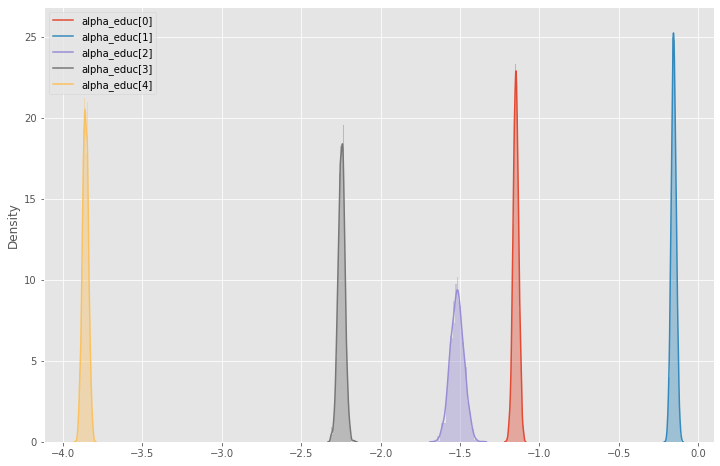

In [151]:
n_cat = 5
for c in range(n_cat):
    sns.distplot(params_samples["alpha_educ"][:,c])
plt.legend(["alpha_educ[%d]" % c for c in range(n_cat)])
plt.show()

In [152]:
#n_cat = 50
#for c in range(n_cat):
#    sns.distplot(params_samples["alpha_state"][:,c])
#plt.legend(["alpha_state[%d]" % c for c in range(n_cat)])
#plt.show()

/Users/kuba/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


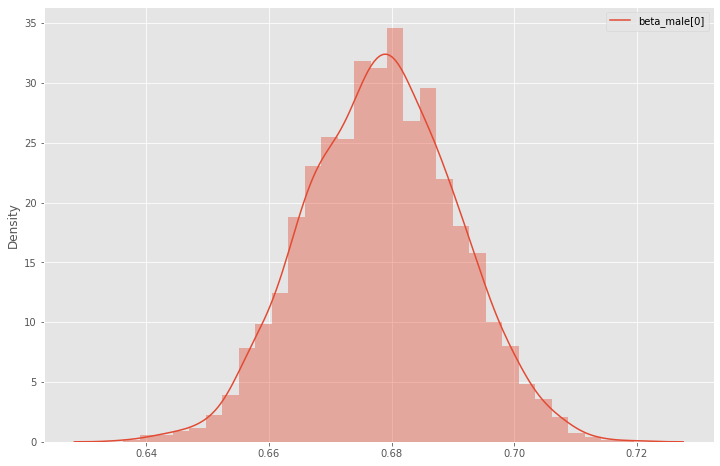

In [153]:
n_cat = 1
for c in range(n_cat):
    sns.distplot(params_samples["beta_male"][:,c])
plt.legend(["beta_male[%d]" % c for c in range(n_cat)])
plt.show()

In [154]:
# extract expected values of the parameters
params_hat = {}
for param in params:
    params_hat[param] = samples[param].mean(axis=0).detach().numpy()
#params_hat

In [155]:
# make predictions for the train set
def sigmoid_n(x):
    x = x.numpy()
    return 1 / (1 + np.exp(-x))
state = X[:,0].int().tolist()
eth = X[:,1].int().tolist()
male = X[:,2].int().tolist()
male_t = X[:,2].numpy()
age = X[:,3].int().tolist()
educ = X[:,4].int().tolist()
y_hat = np.round(sigmoid_n(params_hat["gammas"][5]+ params_hat["gammas"][6]* states_x[:,0][state]+ params_hat["gammas"][states_x[:,1][state].int().tolist()] +params_hat["alpha_educ"][educ]+ params_hat["alpha_eth"][eth] + params_hat["alpha_age"][age] + params_hat["alpha_male_eth"][male, eth] + params_hat["alpha_educ_age"][educ, age] + params_hat["alpha_educ_eth"][educ, eth] +params_hat["beta_male"]*male_t))
y_true = y.numpy()
print("predictions:", y_hat)
print("true values:", y_true)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_true) / len(y_true))

predictions: [0. 1. 0. ... 0. 0. 1.]
true values: [1. 1. 1. ... 0. 0. 0.]
Accuracy: 0.5961879284400602


# Guessing zeros everywhere: (Baseline)

In [177]:
np.sum(np.zeros(len(y_true)) == y_true)/len(y_true)

0.5658418324694867

# Logistic regression